### Part 0: Jax/Numpy API

In [2]:
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt 
import jax

try: 
    import rich
except ModuleNotFoundError:
    print("rich not found, install it with pip install rich")
    !pip install rich

In [3]:
x = jnp.array([1.0, 2.0, 3.0])

print(f"{x=}")
print(f"{type(x)=}")

x=Array([1., 2., 3.], dtype=float32)
type(x)=<class 'jaxlib.xla_extension.ArrayImpl'>


Most numpy functions are available with the `jax.numpy` namespace.

In [4]:
jnp.square(x)

Array([1., 4., 9.], dtype=float32)

Use `onp` to convert Jax arrays to Numpy arrays.

In [5]:
onp.square(x)

array([1., 4., 9.], dtype=float32)

In [6]:
type(onp.square(x))

numpy.ndarray

Unlike NumPy, JAX arrays are immutable,

In [7]:
x_onp = onp.arange(0.0, 10.0)
x_onp[:5] = -1.0
x_onp

array([-1., -1., -1., -1., -1.,  5.,  6.,  7.,  8.,  9.])

In [8]:
x_jnp = jnp.arange(0.0, 10.0)
x_jnp[:5] = -1.0
x_jnp

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

meaning any modification requires creating a new array rather than altering the original.

In [9]:
x_jnp = jnp.arange(0.0, 10.0)
x_jnp = x_jnp.at[:5].set(-1.0)
x_jnp

Array([-1., -1., -1., -1., -1.,  5.,  6.,  7.,  8.,  9.], dtype=float32)

### Part 1: Jax as a tool for computing gradients

In [8]:
from jax import grad

Consider the function

$f(x, y, z) = \sin(x) + e^y + \sqrt{x}$

In [9]:
def f(X):
    x, y, z = X
    return jnp.sin(x) + jnp.exp(y) + jnp.sqrt(z)

It has partial derivatives

$\frac{\partial f}{\partial x} = \cos(x)$

$\frac{\partial f}{\partial y} = e^y$

$\frac{\partial f}{\partial z} = \frac{1}{2\sqrt{z}}$

which can be computed exactly with `jax.grad`:

In [ ]:
dfdX = grad(f)

dfdX(jnp.array([0.0, 0.0, 0.0]))

Now let's add a parameter $h$:

$f(x, y, z; h) = \sin(x-h) + e^{y-h} + \sqrt{z-h}$

This gives a new partial derivative:

$\frac{\partial f}{\partial h} = -\cos(x-h) - e^{y-h} - \frac{1}{2\sqrt{z-h}}$

By specifying `argnums`, we can compute $\frac{\partial f}{\partial h}$:

In [ ]:
def f(X, h):
    x, y, z = X
    return jnp.sin(x - h) + jnp.exp(y - h) + jnp.sqrt(z - h)


grad(f, argnums=1)(jnp.array([0.0, 0.0, 0.25]), 0.0)

Now, let's talk Jacobians and Hessians.

In [12]:
from jax import jacobian, hessian

Let's consider a vector function

$$
\vec{f}(u, v) =
\left[\begin{array}{c} 
e^u \cos(v)\\
e^u \sin(v)
\end{array}\right]
$$ 

In [13]:
def fvec(X):
    u, v = X
    return jnp.array([jnp.exp(u) * jnp.cos(v), jnp.exp(u) * jnp.sin(v)])

The Jacobian of $\vec{f}$ can be written as

$$
\mathbf{J}_{\vec{f}}=
\left[\begin{array}{cc} 
e^u \cos(v) & -e^u \sin(v)\\
e^u \sin(v) & e^u \cos(v)
\end{array}\right]
$$ 

and exactly computed with `jax.jacobian`:

In [ ]:
fjac = jacobian(fvec)
fjac(jnp.array([0.0, 0.0]))

Similarly, the Hessian of $\vec{f}$
$$
\mathbf{J}_{\vec{f}}=
\left[
\left[\begin{array}{cc} 
e^u \cos(v) & -e^u \sin(v)\\
-e^u \sin(v) & -e^u \cos(v)
\end{array}\right],
\left[\begin{array}{cc} 
e^u \sin(v) & e^u \cos(v)\\
e^u \cos(v) & -e^u \sin(v)
\end{array}\right]
\right]
$$

can be computed exactly with `jax.hessian`:

In [ ]:
fhes = hessian(fvec)
fhes(jnp.array([0.0, 0.0]))

### Part 2: Banjamin

### Part 3: Matt

Let us see what devices we have available

In [10]:
jax.devices()

[CpuDevice(id=0)]

We can attach an array to a device

In [11]:
arr = jnp.arange(32.0).reshape(4, 8)
arr.devices()

{CpuDevice(id=0)}

We can use a cool tool to visualise the partitioning

In [12]:
jax.debug.visualize_array_sharding(arr)

                                                  
                                                  
                                                  
                                                  
                                                  
                      CPU 0                       
                                                  
                                                  
                                                  
                                                  
                                                  

In [13]:
from jax.sharding import PartitionSpec as P

n = jax.device_count()
print(f"Sharding overs {n} devices")

mesh = jax.make_mesh((n, 1), ('x', 'y'))
sharding = jax.sharding.NamedSharding(mesh, P('x', 'y'))
print(sharding)

Sharding overs 1 devices
NamedSharding(mesh=Mesh('x': 1, 'y': 1), spec=PartitionSpec('x', 'y'), memory_kind=unpinned_host)


In [14]:
arr_sharded = jax.device_put(arr, sharding)

print(arr_sharded)
jax.debug.visualize_array_sharding(arr_sharded)

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]]


                                                  
                                                  
                                                  
                                                  
                                                  
                      CPU 0                       
                                                  
                                                  
                                                  
                                                  
                                                  

Now you can use JIT to let the XLA compilers in JAX perform the optimal load management

In [15]:
@jax.jit
def f_contract(x):
  return x.sum(axis=0)

result = f_contract(arr_sharded)
jax.debug.visualize_array_sharding(result)
print(result)

  CPU 0  
         

[48. 52. 56. 60. 64. 68. 72. 76.]


Demo of vmap -- automatic vectorization

In [16]:
a = jnp.array([1.0, 4.0, 0.5])
b = jnp.arange(5, 10, dtype=jnp.float32)
def weighted_mean(a, b):
    output = []
    for idx in range(1, b.shape[0]-1):
        output.append(jnp.mean(a + b[idx-1 : idx+2]))
    return jnp.array(output)
print(f"a shape: {a.shape}")
print(f"b shape: {b.shape}")
output = weighted_mean(a, b)
print(f"output: {output.shape}")

a shape: (3,)
b shape: (5,)
output: (3,)


In [17]:
# Let's include the batch dim to the inputs
batch_size = 8
batched_a = jnp.stack([a] * batch_size)
batched_b = jnp.stack([b] * batch_size)
print(f"batched_a shape: {batched_a.shape}")
print(f"batched_b shape: {batched_b.shape}")

batched_a shape: (8, 3)
batched_b shape: (8, 5)


In [18]:
batched_output = jax.vmap(weighted_mean)(batched_a, batched_b)
print(f"batched output shape: {batched_output.shape}")
print(f"batched output:")
print(batched_output)

batched output shape: (8, 3)
batched output:
[[7.8333335 8.833334  9.833334 ]
 [7.8333335 8.833334  9.833334 ]
 [7.8333335 8.833334  9.833334 ]
 [7.8333335 8.833334  9.833334 ]
 [7.8333335 8.833334  9.833334 ]
 [7.8333335 8.833334  9.833334 ]
 [7.8333335 8.833334  9.833334 ]
 [7.8333335 8.833334  9.833334 ]]


In [19]:
# lets compare the runtimes
import time

n = [1000, 2000, 4000, 8000, 16000, 32000, 64000]
time_loop = []
time_vmap = []
for iters in n:
    start = time.time()
    for i in range(iters):
        weighted_mean(a, b)
    time_loop.append(time.time() - start)
    
    batch_size = iters
    batched_a = jnp.stack([a] * batch_size)
    batched_b = jnp.stack([b] * batch_size)
    start = time.time()
    jax.vmap(weighted_mean)(batched_a, batched_b)
    time_vmap.append(time.time() - start)

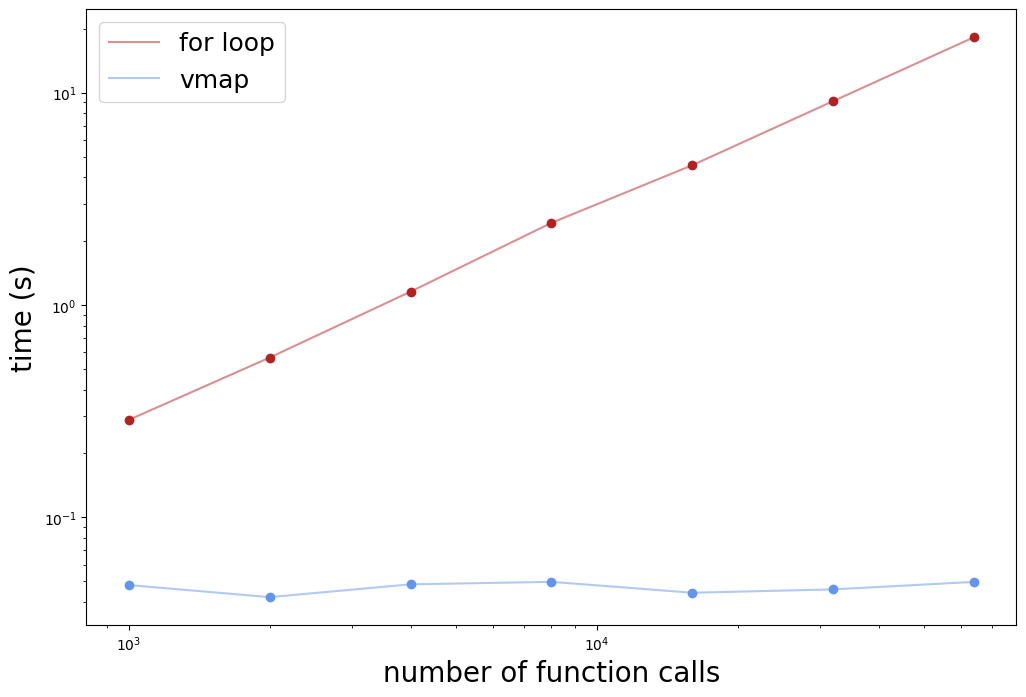

In [20]:
fig = plt.figure(figsize=(12,8))
plt.plot(n, time_loop, label="for loop", alpha=0.5, c='firebrick')
plt.scatter(n, time_loop, c='firebrick')
plt.plot(n, time_vmap, label="vmap", alpha=0.5, c='cornflowerblue')
plt.scatter(n, time_vmap, c='cornflowerblue')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("number of function calls", fontsize=20)
plt.ylabel("time (s)", fontsize=20)
plt.legend(fontsize=18)
plt.show();